In [6]:
__author__ = "Marcelo Gallegos Ortiz"
__description1__ = 'Código fuente implementado en el caso de estudio a presentar en la asignatura de Algoritmos Modernos'

In [7]:
import time
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ortools.linear_solver import pywraplp
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image

Datos (compilacion)

In [8]:
def create_capacityallocation_model():
    data = {} #Definir el diccionario.

    n_carros = 6 #Numero de carros del convoy.
    teu = [2,2,2,2,2,2,
           2,2,1,1,1,1,
           1,1,1,1,1,1,
           1] #PESO. Dimensión del contenedor: 2- 2 TEU(40ft); 1- 1 TEU(20ft).
    tarifa = [2,2,2,3,4,5,
              1,2,1,3,1,1,
              3,2,2,1,2,1,
              1] #VALOR: Importancia (monetaria) de cada contenedor.
    capacidad_carro = [4,4,4,4,4,2] #CAPACIDAD. Capacidad de TEUs por carro.

    data['teu'] = teu #Incluir los TEUs de cada contenedor al diccionario.
    data['tarifa'] = tarifa #Incluir la Tarifa de Ingreso de cada contenedor al diccionario.
    data['capacidad_carro'] = capacidad_carro #Incluir la Capacidad por carro al diccionario.
    data['contenedor'] = list(range(len(teu))) #Lista de contenedores.
    data['carro'] = list(range(n_carros)) #Lista de carros.

    return data

In [9]:
def main():
    data = create_capacityallocation_model()
    solver = pywraplp.Solver.CreateSolver('SCIP')

#VARIABLES
#Binaria de asignación: x_ij = 1, si el contenedor i es asignado al carro j; 0 eoc.
    x = {}
    for i in data['contenedor']:
        for j in data['carro']:
            x[(i, j)] = solver.IntVar(0, 1, 'x_%i_%i' % (i, j))

#RESTRICCIONES
#1.Asignacion: Cada contenedor es asignado a un único carro.
    for i in data['contenedor']:
        solver.Add(sum(x[i, j] for j in data['carro']) <= 1)

#2.Capacidad de Carro: Cantidad de volumen (contenedores) no excede la capacidad del carro.
    for j in data['carro']:
        solver.Add(sum(x[(i, j)] * data['teu'][i] for i in data['contenedor']) <= data['capacidad_carro'][j])

#3.Double-Stack: La configuración sólo puede corresponder a: 1- 40f(down)+40f(up); 2- 20f/20f(down)+40f(up); 3- 20f/20f(down); 4- 20f(down)
    for j in data['carro']:
        if data['capacidad_carro'][j] == 4:
            solver.Add(sum(x[(i, j)] * data['teu'][i] for i in data['contenedor']) == 4)
        elif data['capacidad_carro'][j] == 2:
            solver.Add(sum(x[(i, j)] * data['teu'][i] for i in data['contenedor']) <= 2)

#FUNCIÓN OBJETIVO
    objective = solver.Objective()
    for i in data['contenedor']:
        for j in data['carro']:
            objective.SetCoefficient(x[(i, j)], data['tarifa'][i])
    objective.SetMaximization()

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        print("PLAN DE ASIGNACIÓN", '\n')
        teu_total = 0
        for j in data['carro']:
            teu_carro = 0
            tarifa_carro = 0
            contenedores = 0
            print('Carro N°', j+1)
            for i in data['contenedor']:
                if x[i, j].solution_value() > 0:
                    print('Contenedor', i+1, '- TEU:', data['teu'][i], 'Ingreso Tarifa:', data['tarifa'][i])
                    teu_carro += data['teu'][i]
                    tarifa_carro += data['tarifa'][i]
                    contenedores += 1
            print('Total TEUs cargados por el Carro:', teu_carro)
            print('Total Ingresos por el Carro:', tarifa_carro)
            if teu_carro == 4:
                if contenedores == 4:
                    img_array=plt.imread("imagenes/Carro_4-20.png") 
                    plt.imshow(img_array)
                    plt.title("UP: 20f + 20f \n DOWN: 20f + 20f")
                    plt.axis('off')
                    plt.show()
                elif contenedores == 3:
                    img_array=plt.imread("imagenes/Carro_1-40_2-20.png") 
                    plt.imshow(img_array)
                    plt.title("UP: 40f \n DOWN: 20f + 20f")
                    plt.axis('off')
                    plt.show()
                elif contenedores == 2:
                    img_array=plt.imread("imagenes/Carro_2-40.png") 
                    plt.imshow(img_array)
                    plt.title("UP: 40f \n DOWN: 40f")
                    plt.axis('off')
                    plt.show()
            elif teu_carro == 2:
                if contenedores == 2:
                    img_array=plt.imread("imagenes/Carro_2-20.png") 
                    plt.imshow(img_array)
                    plt.title("DOWN: 20f + 20f")
                    plt.axis('off')
                    plt.show()
                elif contenedores == 1:
                    img_array=plt.imread("imagenes/Carro_1-40.png") 
                    plt.imshow(img_array)
                    plt.title("DOWN: 40f")
                    plt.axis('off')
                    plt.show()
            elif teu_carro == 1:
                img_array=plt.imread("imagenes/Carro_1-20.png") 
                plt.imshow(img_array)
                plt.title("DOWN: 20f")
                plt.axis('off')
                plt.show()
            teu_total += teu_carro
        print('\n''RESULTADO')
        print('Total Ingreso transportado:', objective.Value())       
        print('Total TEUs transportado:', teu_total)
    else:
        print('Sin solución')

PLAN DE ASIGNACIÓN 

Carro N° 1
Contenedor 8 - TEU: 2 Ingreso Tarifa: 2
Contenedor 15 - TEU: 1 Ingreso Tarifa: 2
Contenedor 17 - TEU: 1 Ingreso Tarifa: 2
Total TEUs cargados por el Carro: 4
Total Ingresos por el Carro: 6


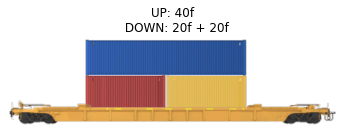

Carro N° 2
Contenedor 2 - TEU: 2 Ingreso Tarifa: 2
Contenedor 10 - TEU: 1 Ingreso Tarifa: 3
Contenedor 13 - TEU: 1 Ingreso Tarifa: 3
Total TEUs cargados por el Carro: 4
Total Ingresos por el Carro: 8


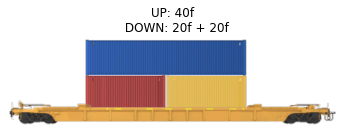

Carro N° 3
Contenedor 6 - TEU: 2 Ingreso Tarifa: 5
Contenedor 16 - TEU: 1 Ingreso Tarifa: 1
Contenedor 19 - TEU: 1 Ingreso Tarifa: 1
Total TEUs cargados por el Carro: 4
Total Ingresos por el Carro: 7


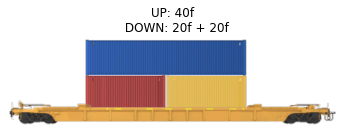

Carro N° 4
Contenedor 1 - TEU: 2 Ingreso Tarifa: 2
Contenedor 3 - TEU: 2 Ingreso Tarifa: 2
Total TEUs cargados por el Carro: 4
Total Ingresos por el Carro: 4


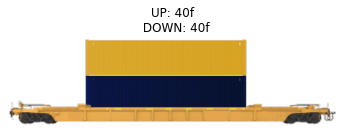

Carro N° 5
Contenedor 4 - TEU: 2 Ingreso Tarifa: 3
Contenedor 5 - TEU: 2 Ingreso Tarifa: 4
Total TEUs cargados por el Carro: 4
Total Ingresos por el Carro: 7


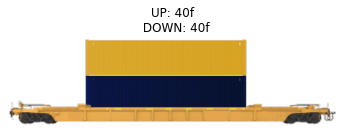

Carro N° 6
Contenedor 9 - TEU: 1 Ingreso Tarifa: 1
Contenedor 11 - TEU: 1 Ingreso Tarifa: 1
Contenedor 12 - TEU: 1 Ingreso Tarifa: 1
Contenedor 14 - TEU: 1 Ingreso Tarifa: 2
Total TEUs cargados por el Carro: 4
Total Ingresos por el Carro: 5


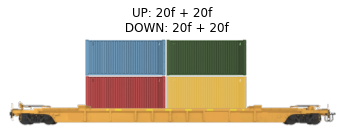


RESULTADO
Total Ingreso transportado: 37.0
Total TEUs transportado: 24


In [10]:
if __name__ == '__main__':
    main()